# Utilities and helper functions (optional)
Adapted from [here](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#preparing-your-data-for-training-with-dataloaders)

In [98]:
def plot_dataset(dataset, label_mapping):
    figure = plt.figure(figsize=(10, 10))
    cols, rows = 3, 3
    for i in range(1, cols * rows + 1):
        sample_idx = torch.randint(len(training_data), size=(1,)).item()
        img, label = training_data[sample_idx]
        img = img.numpy() #.astype(np.uint8)
#         print(np.amin(img), np.amax(img))
        img = np.transpose(img, (1, 2, 0))
        figure.add_subplot(rows, cols, i)
        plt.title(label_mapping[label])
        plt.axis("off")
        plt.imshow(img.squeeze())
    plt.show()

# Pytorch DataSets and Dataloaders
To facilitate model training, we need to be able to load data during the training step. This data often undergoes transformations to prepare it for training and we want to separate this loading and transformation logic from model training code. We use the following primities.

 1. [torch.utils.data.Dataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset): Stores samples and their labels if supervised learning.
 2. [torch.utils.data.DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): Wraps an iterable around the Dataset so that we can loop through samples. 

For more technical info on DataSet have a look [here](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset).

Many tutorials use pre-existing [datasets](https://pytorch.org/vision/stable/datasets.html). We will build our own on a new dataset.

## PACS Dataset

We will use the dataset introduced in [Deeper, Broader and Artier Domain Generalisation](https://openaccess.thecvf.com/content_ICCV_2017/papers/Li_Deeper_Broader_and_ICCV_2017_paper.pdf).

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  overflow:hidden;padding:10px 5px;word-break:normal;}
.tg th{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  font-weight:normal;overflow:hidden;padding:10px 5px;word-break:normal;}
.tg .tg-baqh{text-align:center;vertical-align:top}
</style>
<table class="tg">
<thead>
  <tr>
    <th class="tg-baqh">Dog</th>
    <th class="tg-baqh">Elephant</th>
    <th class="tg-baqh">Giraffe</th>
    <th class="tg-baqh">Guitar</th>
    <th class="tg-baqh">Horse</th>
    <th class="tg-baqh">House</th>
    <th class="tg-baqh">Person</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td class="tg-baqh"><img src="images/dog.jpg"></td>
    <td class="tg-baqh"><img src="images/elephant.jpg"></td>
    <td class="tg-baqh"><img src="images/giraffe.jpg"></td>
    <td class="tg-baqh"><img src="images/guitar.png"></td>
    <td class="tg-baqh"><img src="images/horse.jpg"></td>
    <td class="tg-baqh"><img src="images/house.jpg"></td>
    <td class="tg-baqh"><img src="images/person.jpg"></td>
  </tr>
</tbody>
</table>

We will get the labels from the file path: `Data/PACS/sketch/horse/n02374451_597-3.png`

# Dataset

In [95]:
from torch.utils.data import Dataset
import torch
from pathlib import Path
from torchvision.io import read_image
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np

class PACSDataset(Dataset):
    # Required
    def __init__(self, file_names, transform=None):
        """
        Args:
            file_names (list): list of file names for images of the dataset (train or test split).
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.label_mapping = {"dog": 0,
                              "elephant": 1, 
                              "giraffe": 2, 
                              "guitar": 3, 
                              "horse": 4, 
                              "house": 5, 
                              "person": 6
                             }
    
        self.file_names = file_names
        self.transform = transform

    # Required   
    def __len__(self):
        return len(self.file_names)
    
    def get_label(self, file_name):
        image_path = Path(file_name)
        return image_path.parent.name
    
    # Required
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = self.file_names[idx]
        image = read_image(img_name)#io.imread(img_name)
        image = image.type(torch.FloatTensor)/255
#         image = Image.fromarray(image, mode = 'RGB')        
        label = self.get_label(img_name)
        label = self.label_mapping[label]

        if self.transform:
            image = self.transform(image)
                    
        return (image, label)


### Some tips
1. Make sure images are float32
2. Make sure images are between 0 and 4

### Does it work?
It is always a good idea to test out a unit of code before integrating it into a larger piece of software. In our case we want to test the dataset before using it to train models. It is possible that low model performance can be due to bad input (corrupted images, incorrect encodings used, or blank images due to error in transformations, incorrect labels).

One way to informally test a Dataset  is to visualise random samples. We will use the utility function defined at the top of the notebook for this purpose. 

In [96]:
with open("train_files.txt") as f:
    file_names = f.read().splitlines()
    
training_data = PACSDataset(file_names)

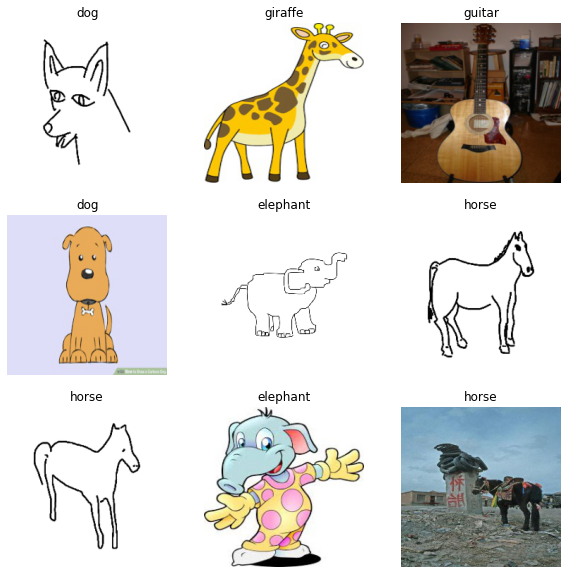

In [99]:
# label mapping used for plotting
label_mapping = {0: "dog", 1: "elephant", 2: "giraffe", 3:"guitar", 4: "horse", 5:"house", 6: "person"}
plot_dataset(training_data, label_mapping)

## Dataloader
When iterating through a DataSet, we have to do it one sample at a time. However, we want to train with something like mini-batch gradient descent so we need access to mini-batches during training. 

In [100]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(training_data, batch_size=9, shuffle=True)
image_batch, label_batch = next(iter(train_dataloader))

In [101]:
for idx, image in enumerate(image_batch):
    print(idx, image.shape)

0 torch.Size([3, 227, 227])
1 torch.Size([3, 227, 227])
2 torch.Size([3, 227, 227])
3 torch.Size([3, 227, 227])
4 torch.Size([3, 227, 227])
5 torch.Size([3, 227, 227])
6 torch.Size([3, 227, 227])
7 torch.Size([3, 227, 227])
8 torch.Size([3, 227, 227])


In [104]:
def plot_dataloader(image_batch, label_batch, label_mapping):
    figure = plt.figure(figsize=(10, 10))
    cols, rows = 3, 3
    for i, image in enumerate(image_batch):
        img, label = image, label_batch[i]
        img = img.numpy() #.astype(np.uint8)
        img = np.transpose(img, (1, 2, 0))
        figure.add_subplot(rows, cols, i+1)
        plt.title(label_mapping[int(label)])
        plt.axis("off")
        plt.imshow(img.squeeze())
    plt.show()

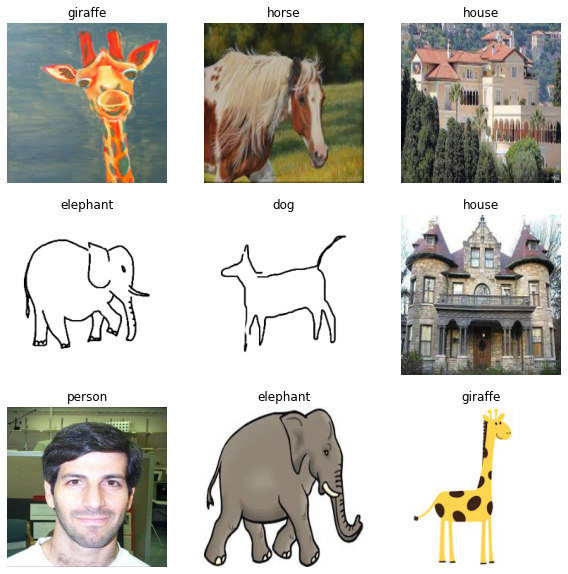

In [105]:
plot_dataloader(image_batch, label_batch, label_mapping)